# Complex source reconstruction using _starlets_
This notebooks aims to be a first tentative to express light on pixelated grid, and building the mapping between source and image planes, for an implementation in _lenstronomy_.

In [1]:
__author__ = 'aymgal'
import os
import sys
import copy
import time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.util import dirac_impulse
from slitronomy.Util.plot_util import nice_colorbar

%matplotlib inline

lensing_operator = 'interpol'  # 'interpol' or 'simple'
subgrid_res_source = 2

minimal_source_plane = True
use_threshold_mask = False

source_type = 'galsim'  # 'sersic', 'double_sersic', 'triple_sersic'

formulation = 'analysis'
perfect_seeing = False


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.17.0    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Generate a mock lens

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(41, 41) (82, 82)


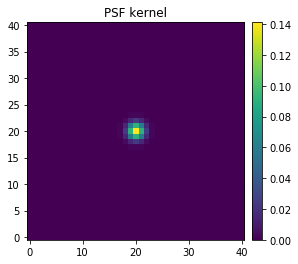

In [5]:
# PSF specification
if perfect_seeing:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    psf_kernel_hd = kernel_util.kernel_gaussian(int(psf_num_pix*subgrid_res_source), 
                                                  delta_pix/subgrid_res_source, 
                                                  psf_fwhm)
    print(psf_kernel.shape, psf_kernel_hd.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
if source_type == 'galsim':
    # get an pre-processed source galaxy from galsim
    galsim_index = 31
    galsim_data_path = ('data/ring_sims/simring_galsim{}_all.pkl'.format(galsim_index))
    [data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
    galsim_source_highres = truth['source_galsim_3']
    galsim_num_pix = data['num_pix']
    galsim_delta_pix = data['delta_pix']
    source_model_list = ['INTERPOL']
    kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 3000, 'center_x': -0.1, 'center_y': -0.1, 'phi_G': np.pi/8., 
                              'scale': galsim_delta_pix/3.}
    kwargs_source = [kwargs_interpol_source]
elif source_type == 'sersic':
    source_model_list = ['SERSIC_ELLIPSE']
    kwargs_sersic_ellipse_source = {'amp': 100, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                    'center_x': 0.1, 'center_y': 0.2}
    kwargs_source = [kwargs_sersic_ellipse_source]
elif source_type == 'double_sersic':
    source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
    kwargs_sersic_ellipse_source2 = {'amp': 100, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                    'center_x': 0.3, 'center_y': 0.3}
    kwargs_sersic_ellipse_source1 = {'amp': 80, 'R_sersic': 0.4, 'n_sersic': 1, 'e1': -0.02, 'e2': 0.02,
                                    'center_x': -0.2, 'center_y': 0.5}
    kwargs_source = [kwargs_sersic_ellipse_source1, kwargs_sersic_ellipse_source2]
elif source_type == 'triple_sersic':
    source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
    kwargs_sersic_ellipse_source1 = {'amp': 100, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                    'center_x': 0.3, 'center_y': 0.3}
    kwargs_sersic_ellipse_source2 = {'amp': 60, 'R_sersic': 0.4, 'n_sersic': 1, 'e1': -0.02, 'e2': 0.02,
                                    'center_x': -0.05, 'center_y': -0.1}
    kwargs_sersic_ellipse_source3 = {'amp': 60, 'R_sersic': 0.4, 'n_sersic': 1, 'e1': -0.02, 'e2': 0.02,
                                    'center_x': -0.2, 'center_y': 0.7}
    kwargs_source = [kwargs_sersic_ellipse_source1, kwargs_sersic_ellipse_source2, kwargs_sersic_ellipse_source3]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

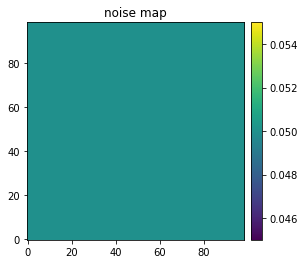

In [7]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("noise map")
im = plt.imshow(np.sqrt(data_class.C_D), origin='lower')
nice_colorbar(im)
plt.show()

In [8]:
# get the coordinates arrays of source plane (those are 'thetas' but in source plane !)
x_grid_src_1d, y_grid_src_1d = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix, 
                                                      subgrid_res=subgrid_res_source)
# get the light distribution in source plane on high res grid
source_sim_1d_hd = source_model_class.surface_brightness(x_grid_src_1d, y_grid_src_1d, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_1d_hd)

# get the light distribution in source plane
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

# get the light distribution in source plane convolved
source_sim_conv = imageModel.source_surface_brightness(kwargs_source, unconvolved=False, de_lensed=True)
source_sim_1d_conv = lenstro_util.image2array(source_sim)

# get the light distribution in source plane, convolved and on high res grid
from lenstronomy.ImSim.Numerics.convolution import PixelKernelConvolution
conv_hd = PixelKernelConvolution(psf_kernel_hd, convolution_type='fft_static')
source_sim_hd_conv = np.copy(conv_hd.convolution2d(source_sim_hd))


In [9]:
# get an automatic mask that includes the lensed source light
threshold_noise = 5
image_mask_1d = np.zeros_like(image_sim_1d)
mask_indices = np.where(image_sim_1d > threshold_noise * background_rms)
image_mask_1d[mask_indices] = 1
image_mask = lenstro_util.array2image(image_mask_1d)

## Visualize the lens & true source

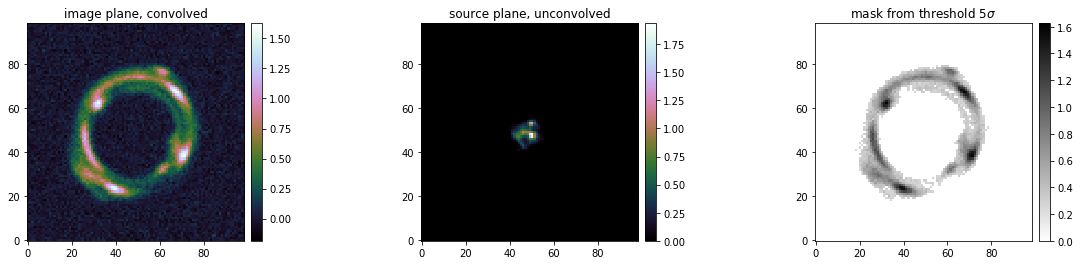

In [10]:
fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 3), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
ax.set_title("mask from threshold {}$\sigma$".format(threshold_noise))
im = ax.imshow(image_mask*image_sim, origin='lower', cmap='gray_r')
nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 2))
#ax.set_title(r"$\alpha_x$")
#im = ax.imshow(alpha_x, origin='lower', cmap='seismic')
#nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 3))
#ax.set_title(r"$\alpha_y$")
#im = ax.imshow(alpha_y, origin='lower', cmap='seismic')
#nice_colorbar(im)

plt.show()

## Sparse optimizazion to reconstruct the source light

In [11]:
source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': 6, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

if use_threshold_mask:
    likelihood_mask = image_mask.astype(bool)
else:
    likelihood_mask = None

kwargs_sparse_solver = {
    'lensing_operator': lensing_operator,  # 'simple' or 'interpol'
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': minimal_source_plane,
    'min_num_pix_source': 69,
    
    'formulation': formulation,
    'initial_guess': 'noise_map',  # or 'background_rms' for just initializing with gaussian noise
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 5,
    'max_threshold_high_freq': 10,
    'num_iter': 80,
    'num_iter_weights': 1,
    'verbose': True,
    'show_steps': True,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)


INFO : source grid has been reduced from 198 to 142 side pixels


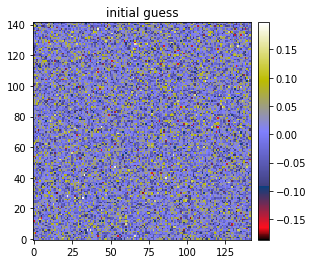

=== iteration 0-0 === : loss = 5.1188|nan, red-chi2 = 1.9572|nan, step_diff = 142.5964|nan


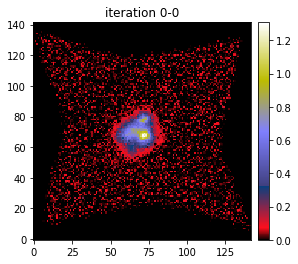

=== iteration 0-30 === : loss = 0.9042|nan, red-chi2 = 0.9721|nan, step_diff = 0.0002|nan


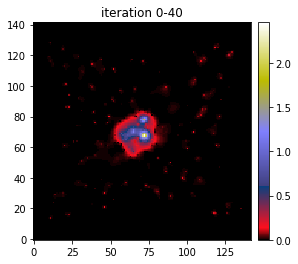

=== iteration 0-60 === : loss = 0.9026|nan, red-chi2 = 0.9689|nan, step_diff = 0.0000|nan


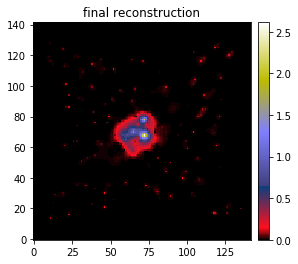

Runtime : 9.963 s


In [12]:
kwargs_lens_mod = copy.deepcopy(kwargs_lens)
#kwargs_lens_mod[0]['gamma'] = kwargs_lens[0]['gamma'] * 1.1

start_time = time.time()
model, model_error = imageSparseFit.image_sparse_solve(kwargs_lens_mod, 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_lens_light=None,
                                                       kwargs_special=kwargs_special_sparsefit)
end_time = time.time()
print("Runtime : {:.3f} s".format(end_time-start_time))

## Plot results in image plane

Negative source pixels ? False (min = 0.00e+00)
Negative image pixels ? False (min = 6.62e-13)


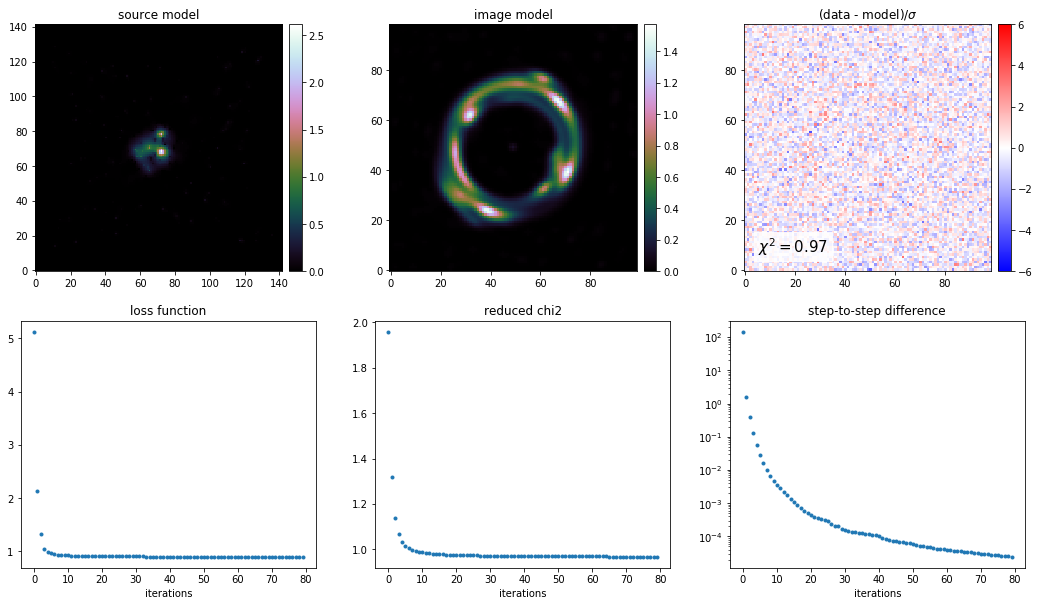

In [13]:
sparseSolver = imageSparseFit.sparseSolver
#lensingOperator = imageSparseFit.lensingOperator

fig = sparseSolver.plotter.plot_results(model_log_scale=False, res_vmin=-6, res_vmax=6)

## Plot residuals in source plane

In [14]:
print("Updated kwargs :", kwargs_source_sparsefit)
print(kwargs_source_sparsefit[0]['coeffs'].shape)

Updated kwargs : [{'n_scales': 6, 'n_pixels': 20164, 'scale': 0.039999999999999994, 'coeffs': array([0.        , 0.        , 0.        , ..., 0.00075191, 0.0007223 ,
       0.00069256])}]
(120984,)


1.9354066125246496 406.37063024546234 2.002588866278532 2.6148888990282995


/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


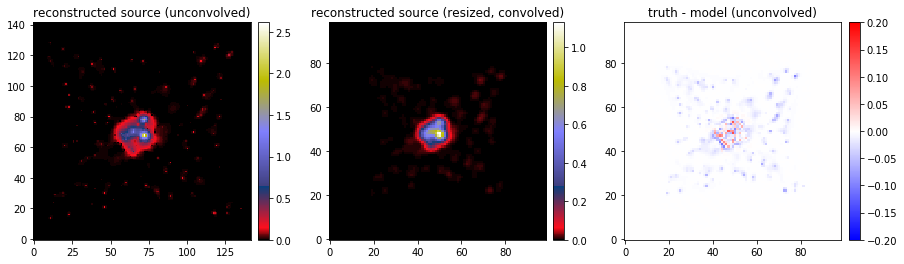

In [15]:
source_estimate = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                           unconvolved=True, de_lensed=True, re_sized=True,
                                                           original_grid=True)

source_estimate_conv = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                           unconvolved=False, de_lensed=True, re_sized=True,
                                                           original_grid=True)

source_estimate_hd = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                              unconvolved=True, de_lensed=True, re_sized=False,
                                                              original_grid=True)
source_estimate_hd_conv = np.copy(conv_hd.convolution2d(source_estimate_hd))

source_estimate_hd_min_grid = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                           unconvolved=True, de_lensed=True, re_sized=False,
                                                           original_grid=False)

model_unconvolved = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None,
                                                                  unconvolved=True, de_lensed=False)

#plt.imshow(model_unconvolved, origin='lower')
#plt.show()

print(source_sim.max(), source_sim_hd.max(), source_estimate.max(), source_estimate_hd.max())
cut_level = 0.2

#residuals_source = source_sim/source_sim.max() - source_estimate/source_estimate.max()
residuals_source_conv = source_sim_conv - source_estimate_conv
residuals_source = source_sim - source_estimate
residuals_source_hd = source_sim_hd - source_estimate_hd
residuals_source_hd_conv = source_sim_hd_conv - source_estimate_hd_conv

rel_error_source_conv = (source_sim_conv - source_estimate_conv) / source_sim_conv

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("reconstructed source (unconvolved)")
im = ax.imshow(source_estimate_hd_min_grid, origin='lower', cmap='gist_stern')
nice_colorbar(im)
ax = axes[1]
ax.set_title("reconstructed source (resized, convolved)")
im = ax.imshow(source_estimate_conv, origin='lower', cmap='gist_stern')
nice_colorbar(im)
ax = axes[2]
ax.set_title("truth - model (unconvolved)")
im = ax.imshow(residuals_source, origin='lower', cmap='bwr', vmin=-cut_level, vmax=cut_level)
#im = ax.imshow(rel_error_source_conv, origin='lower', cmap='bwr', vmin=-0.2, vmax=0.2)
nice_colorbar(im)
plt.show()

## Check noise propagation

0 0.00040257556
1 0.00021674416
2 0.00012188856
3 6.823551e-05
4 5.909787e-05
5 4.580877e-05


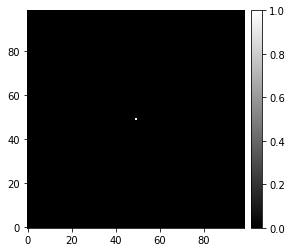

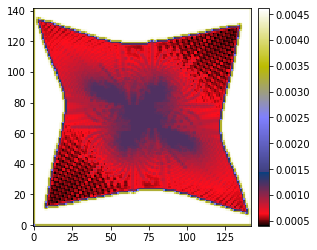

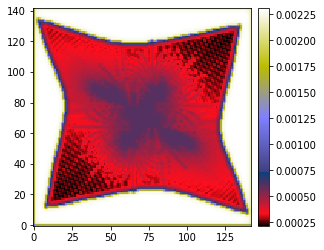

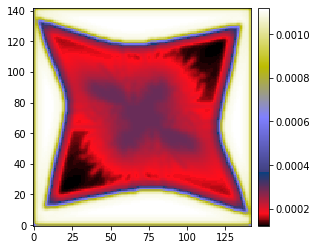

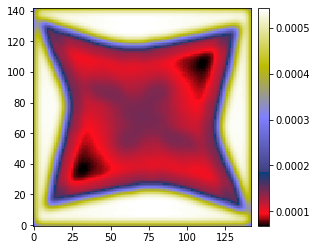

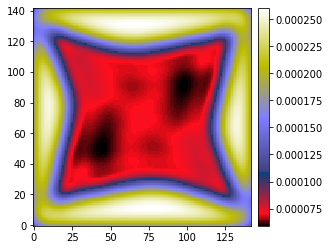

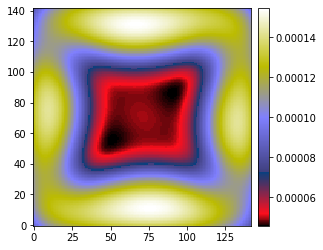

In [16]:
#%matplotlib notebook 
dirac = dirac_impulse(num_pix)
plt.figure()
im = plt.imshow(dirac, origin='lower', cmap='gray')
nice_colorbar(im)

noise_levels = sparseSolver.noise_levels_source_plane
for l in range(noise_levels.shape[0]):
    plt.figure()
    print(l, np.min(noise_levels[l, :, :]))
    im = plt.imshow(noise_levels[l, :, :], origin='lower', cmap='gist_stern')
    nice_colorbar(im)